In [ ]:
'''
Marco Costante, Alex Costanzino, Alessandra Stramiglio, Xiaowei Wen
MSc students in Artificial Intelligence
@ Alma Mater Studiorum, University of Bologna
December, 2021
'''

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
%cd drive/MyDrive/[NLP]/assignment-two

# Assignment No. 2: fact checking, natural language inference
In the last few years, disinformation and fake news have been spreading throughout the world at rates never seen before, creating the need for fact-checking organizations. 
Despite many human-based fact-checking organizations that are currently in operation, disinformation continues to briskly spread throughout the internet, and the existing organizations are unable to keep up.

Automated fact checking refers to the process that seeks to verify factual information with the aim to promote veracity and correctness of the text. 


In [ ]:
import os
import requests
import zipfile

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model, save_model

!pip install focal-loss --quiet
import focal_loss

## Data processing

### Data extraction

In [ ]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # Filter out keep-alive new chunks.
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params = {'id': toy_data_url_id},
                                   stream = True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

### Data loading
We loaded the splits into separate dataframes composed by three columns: `Claim`, `Evidence`, `Label`, dropping everything else.

In [ ]:
import pandas as pd

df_train = pd.read_csv('dataset/train_pairs.csv', sep = ',')
df_train.drop(['Unnamed: 0', 'ID'], axis = 1, inplace = True)

df_val = pd.read_csv('dataset/val_pairs.csv', sep = ',')
df_val.drop(['Unnamed: 0', 'ID'], axis = 1, inplace = True)

df_test = pd.read_csv('dataset/test_pairs.csv', sep = ',')
df_test.drop(['Unnamed: 0', 'ID'], axis = 1, inplace = True)

In [ ]:
# Check.
df_train.head()
# df_val.head()
# df_test.tail()

,Claim,Evidence,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,REFUTES


### Text filtering
We have to remove some spurious words from the sentences:

In [ ]:
import re
from functools import reduce
import nltk
from typing import List, Callable
 
re_remove_number= re.compile('([0-9]\\t|[0-9])')
replace_symbols = re.compile('[/(){}\[\]\|@,;]')
good_symbols = re.compile('[^0-9a-z #+_]')
 
# All function names are self-explainatory.
def remove_leading_tabs(text: str) -> str:
   pattern = r'[0-9]+?\t'
   return re.sub(pattern, '', text)
 
def remove_pronunciations(text: str) -> str:
   pattern = r'-LSB-.*?-RSB-(\s;)*?'
   return re.sub(pattern, '', text)
 
def remove_brackets(text: str) -> str:
   pattern = re.compile('(\-RSB\-|\-RRB\-|\-LSB\-|\-LRB\-)')
   return re.sub(pattern, '', text)
 
def fix_double_dashes(text: str) -> str:
   pattern = r'\-\-'
   return re.sub(pattern, '-', text)
 
def remove_trailing_words(text) :
   pattern = r'.\t.*?$'
   return re.sub(pattern, '.', text)
 
def split_genitive(text: str) -> str:
   pattern = r"(\s.+?)'s"
   return re.sub(pattern, r"\1's", text)
 
def separate_non_words(text) :
   pattern = r'([a-zA-Z]+?)\-([a-zA-Z]+?)'
   return re.sub(pattern, r'\1 - \2', text)
 
def lower(text: str) -> str:
   return text.lower()
 
def remove_initial_no(str:str) -> str:
   return re.sub(re_remove_number,"",str)
 
def replace_special_characters(text: str) -> str:
   return replace_symbols.sub(' ', text)
 
def replace_br(text: str) -> str:
   return text.replace('br', '')
 
def filter_out_uncommon_symbols(text: str) -> str:
   return re.sub(good_symbols, '',text)
 
def remove_stopwords(text: str) -> str:
   return ' '.join([x for x in text.split() if x and x not in stopwords_set])
 
def strip_text(text: str) -> str:
   return text.strip()
 
def remove_langpron(text: str)-> str:
   return text.replace('langpron',"")
 
def remove_dl(text:str)-> str:
   pattern = re.compile('( dl | ul )')
   return re.sub(pattern, '', text)
 
pipeline = [remove_leading_tabs, remove_pronunciations, remove_brackets,
           fix_double_dashes, remove_trailing_words, split_genitive,
           separate_non_words,
           lower, remove_initial_no, replace_special_characters,
           replace_br, filter_out_uncommon_symbols,
           strip_text, remove_langpron]
 
def text_prepare(text: str,
                filter_methods: List[Callable[[str], str]] = None) -> str:
   '''
   Applies a list of pre-processing functions in sequence (reduce).
   Note that the order is important here!
   '''
 
   filter_methods = filter_methods if filter_methods is not None else pipeline
 
   return reduce(lambda txt, f: f(txt), filter_methods, text)
 
def cleaning(dataframes: list, labels: list):
 for dataframe in dataframes:
   print('Before: \n')
   print(dataframe.head(5))
  
   for label in labels:
     dataframe[label] = dataframe[label].apply(lambda txt: text_prepare(txt))
  
   print('After: \n')
   print(dataframe.head(5))
 
datasets_list = [df_train, df_val, df_test]
labels_list = ['Claim', 'Evidence', 'Label']
 
cleaning(datasets_list, labels_list)

Before: 

                                               Claim  ...     Label
0     Chris Hemsworth appeared in A Perfect Getaway.  ...  SUPPORTS
1                            Roald Dahl is a writer.  ...  SUPPORTS
2                          Roald Dahl is a governor.  ...   REFUTES
3        Ireland has relatively low-lying mountains.  ...  SUPPORTS
4  Ireland does not have relatively low-lying mou...  ...   REFUTES

[5 rows x 3 columns]
After: 

                                               Claim  ...     Label
0      chris hemsworth appeared in a perfect getaway  ...  supports
1                             roald dahl is a writer  ...  supports
2                           roald dahl is a governor  ...   refutes
3        ireland has relatively low  lying mountains  ...  supports
4  ireland does not have relatively low  lying mo...  ...   refutes

[5 rows x 3 columns]
Before: 

                                               Claim  ...     Label
0  The Indian Army comprises part of the co

In [ ]:
# Check.
df_train.head()
# df_val.head()
# df_test.head()

,Claim,Evidence,Label
0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,supports
1,roald dahl is a writer,roald dahl september november was...,supports
2,roald dahl is a governor,roald dahl september november was...,refutes
3,ireland has relatively low lying mountains,the island s geography comprises relatively lo...,supports
4,ireland does not have relatively low lying mo...,the island s geography comprises relatively lo...,refutes


In [ ]:
# Copy needed later for the majority vote.
df_test_m = pd.DataFrame.copy(df_test, deep = True)

### Text tokenization
Text tokenization consists into split a whole sentencences into meaningful pieces of it. It is achieved with the punkt tokenizer by NLTK.

In [ ]:
# Note: it takes a while.
from nltk.tokenize import wordpunct_tokenize

def tokenize_dataset(dataframes: list, labels: list):
  for df in dataframes:
    for lab in labels:
      df[lab] = df[lab].apply(wordpunct_tokenize)

# Note: pass just 'Claim' and 'Evidence' otherwise also 'Label' will be turned into a list and following code will fail!
tokenize_dataset(datasets_list, labels = ['Claim', 'Evidence'])

In [ ]:
# Check.
df_train.head()
# df_val.head()
# df_test.head()

,Claim,Evidence,Label
0,"[chris, hemsworth, appeared, in, a, perfect, g...","[hemsworth, has, also, appeared, in, the, scie...",supports
1,"[roald, dahl, is, a, writer]","[roald, dahl, september, november, was, a, iti...",supports
2,"[roald, dahl, is, a, governor]","[roald, dahl, september, november, was, a, iti...",refutes
3,"[ireland, has, relatively, low, lying, mountains]","[the, island, s, geography, comprises, relativ...",supports
4,"[ireland, does, not, have, relatively, low, ly...","[the, island, s, geography, comprises, relativ...",refutes


## Out-of-vocaboulary terms & embedding
At first some functions to handle OOVs terms and token embeddings are define. In particular:
* `build_vocaboulary`: create a double vocaboulary from a dataframe to mantain encode and decode tokens;
* `load_glove_embedding`: given a chosen embedding dimension it downloads the corresponding pre-trained corpus;
* `get_OOV_terms`: given a vocaboulary and a word listings returns the set of OOV terms;
* `build_embedding_matrix`: returns the matrix to pass to the embedding layer as kernel initializer.

In [ ]:
import gensim
import gensim.downloader as gloader

from collections import OrderedDict
from typing import OrderedDict
from tqdm import tqdm
import numpy as np

def build_vocabulary(dataset: pd.DataFrame, labels: list) -> (OrderedDict[int, str], OrderedDict[str, int], list):
    idx2word = OrderedDict()
    word2idx = OrderedDict()
    
    curr_idx = 1 # Start at 1 since 0 is reserved for padding.

    for label in labels:
      for row in tqdm(dataset[label].values):
        for token in row:
            if token not in word2idx:
                word2idx[token] = curr_idx
                idx2word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx2word.values())

    return idx2word, word2idx, word_listing

def load_glove_embedding(embedding_dimension: int) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)

    # Sanity check.
    try:
        embedded_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding dimension.")
        raise e

    return embedded_model

def get_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing: List[str]) -> list:
    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word2idx: OrderedDict[str, int],
                           vocab_size: int) -> np.ndarray:

    # Note: we take (vocab_size) + 1 since we start counting by 1, having reserved 0 for the padding.
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dimension), dtype = np.float32) 

    for word, idx in tqdm(word2idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

emb_dim = 50
embedded_model = load_glove_embedding(embedding_dimension = emb_dim)

[==================================================] 100.0% 66.0/66.0MB downloaded


At first we created the vocabularies of words and tags for the training set, we extracted the out-of-vocabularies (OOV) words for it and then its embedding matrix. We assigned random vectors for the OOV words. We repeated the same process for the validation set, taking into account the fact that the OOV words already considered for the training set, are not OOV words for the validation set. The same was done for the test set.

Then, we concatenated all embedding matrixes into a single one, and merged the various vocabularies into a single one.

In [ ]:
# Step 0: load GloVe vocaboulary.
vocaboulary = list(embedded_model.vocab.keys()) 

# Step 1: creation of vocaboulary for the training set and extraction of his OOVs.
idx2word_train, word2idx_train, word_listing_train = build_vocabulary(df_train, labels_list)

oov_terms_train = get_OOV_terms(embedded_model, word_listing_train)
print(f'There are {len(oov_terms_train)} OOVs in the training set.')

print('\n')

# Step 2: creation of vocaboulary for the validation set and extraction of his OOVs, taking into account the ones already from training set.
idx2word_val, word2idx_val, word_listing_val = build_vocabulary(df_val, labels_list)

oov_terms_val = get_OOV_terms(embedded_model, word_listing_val)
oov_terms_val = list(set(oov_terms_val).difference(set(oov_terms_train)))
print(f'There are {len(oov_terms_val)} new OOVs in the validation set.')

print('\n')

# Step 3: creation of vocaboulary for the test set and extraction of his OOVs.
idx2word_test, word2idx_test, word_listing_test = build_vocabulary(df_test, labels_list)

oov_terms_test = get_OOV_terms(embedded_model, word_listing_test)
oov_terms_test = list(set(oov_terms_test).difference((set(oov_terms_train).union(set(oov_terms_val)))))
print(f'There are {len(oov_terms_test)} new OOVs in the test set.')

print('\n')

# Step 4: merge vocaboulary and OOVs.
vocaboulary = np.concatenate((vocaboulary, oov_terms_train, oov_terms_val, oov_terms_test))

100%|██████████| 121740/121740 [00:00<00:00, 1222715.54it/s]


There are 3028 OOVs in the training set.




100%|██████████| 7165/7165 [00:00<00:00, 1322253.97it/s]


There are 237 new OOVs in the validation set.




100%|██████████| 7189/7189 [00:00<00:00, 862594.45it/s]


There are 288 new OOVs in the test set.




In [ ]:
word2idx = dict(zip(vocaboulary, range(1, len(vocaboulary) + 1))) # Start from 1 since we reserve 0 for padding.

# Whole embedding matrix.
embedding_matrix = build_embedding_matrix(embedded_model, emb_dim, word2idx, len(word2idx))
print("Embedding matrix shape: {}.".format(embedding_matrix.shape))

100%|██████████| 403553/403553 [00:01<00:00, 331179.88it/s]

Embedding matrix shape: (403554, 50).


### Padding and generator creation
We will pad up to the maximum number of token since we need to preserve informative content.

Note that we shouldn't have info on the maximum number of tokens on the test set, but for sake of simplicity we will calculate the number of tokens on the test set as well, in order to avoid splitting and concatenation at inference time.

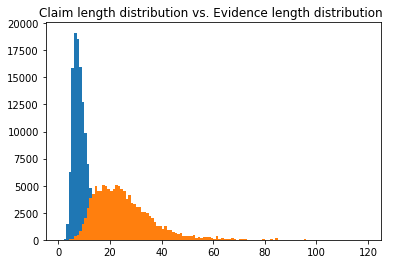

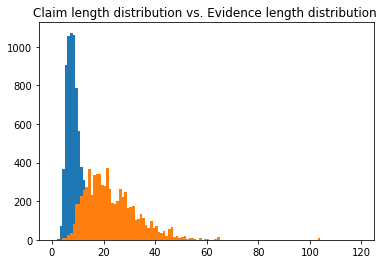

In [ ]:
import matplotlib.pyplot as plt

def extract_info(dataframe: pd.DataFrame) -> int:
  plt.figure()
  plt.title('Claim length distribution vs. Evidence length distribution ')
  
  no_token_claim = [len(sentence) for sentence in dataframe['Claim']]
  n_c, _, _ = plt.hist(no_token_claim, bins = [i for i in range(1, 120)], cumulative = False)

  no_token_evidence = [len(sentence) for sentence in dataframe['Evidence']]
  n_e, _, _ = plt.hist(no_token_evidence, bins = [i for i in range(1, 120)], cumulative = False)

  return max(max(no_token_claim), max(no_token_evidence))

max_tokens = max(extract_info(df_train), extract_info(df_val))

Finally, we put our dataframes into matrixes, padding and truncating the sentences, using the aforementioned vocabulary to encode the words into integers.

In [ ]:
binary_map = {'refutes': 0, 'supports': 1}

def encode_sentence(sentence, word2idx):
  return [word2idx[words] for words in sentence]

def encode_dataframe(dataframe, word2idx):
  encoded_dataframe = pd.DataFrame(columns = ['Claim', 'Evidence', 'Label'])

  for columns in ['Claim', 'Evidence'] :
    encoded_dataframe[columns] = dataframe[columns].apply(lambda sentence: encode_sentence(sentence, word2idx))

  encoded_dataframe['Label'] = dataframe['Label'].map(binary_map)

  return encoded_dataframe

train = encode_dataframe(df_train, word2idx)
val = encode_dataframe(df_val, word2idx)
test = encode_dataframe(df_test, word2idx)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

train_claim = pad_sequences(train['Claim'], maxlen = max_tokens, padding = 'post')
train_evidence = pad_sequences(train['Evidence'], maxlen = max_tokens, padding = 'post')

val_claim = pad_sequences(val['Claim'], maxlen = max_tokens, padding = 'post')
val_evidence = pad_sequences(val['Evidence'], maxlen = max_tokens, padding = 'post')

test_claim = pad_sequences(test['Claim'], maxlen = max_tokens, padding = 'post')
test_evidence = pad_sequences(test['Evidence'], maxlen = max_tokens, padding = 'post')

## Neural architectures

In [ ]:
from tensorflow.keras.layers import SimpleRNN, Bidirectional, Dense, TimeDistributed, Input, Reshape, Embedding, concatenate, add, average, Average, Dropout, dot, maximum
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant, glorot_normal
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy 


# Note: the learning rate is not parametrized since we use a scheduler.
def fact_checker(max_tokens: int, embedding_dimension: int, embedding_matrix: np.ndarray, merge_strategy: str, embedding_strategy: str, cos_similarity: bool, 
                 dropout: float = 0.40, recurrent_dropout: float = 0.25, initial_learning_rate: float = 0.0001) -> Model:
  hidden_nodes = emb_dim

  ''' Network structure '''
  claim_input = Input(shape = (max_tokens, ), name = 'claim_input')

  evidence_input = Input(shape = (max_tokens, ), name = 'evidence_input')

  shared_embedding = Embedding(input_dim = embedding_matrix.shape[0],
                               output_dim = embedding_dimension,
                               mask_zero = True,
                               embeddings_initializer = Constant(embedding_matrix),
                               trainable = False,
                               name = 'embedding_layer')
  
  embedded_claim = shared_embedding(claim_input)
  embedded_evidence = shared_embedding(evidence_input)

  # Sentence encoding
  if embedding_strategy == 'last_state':
    shared_rnn = Bidirectional(SimpleRNN(hidden_nodes,
                                    # return_sequences: whether to return the last output in the output sequence, or the full sequence. 
                                    return_sequences = False, return_state = False,
                                    dropout = dropout, recurrent_dropout = recurrent_dropout, 
                                    name = 'rnn_layer_claim'))

    rnn_layer_claim = shared_rnn(embedded_claim)
    rnn_layer_evidence = shared_rnn(embedded_evidence)

  elif embedding_strategy == 'average_state':
    shared_rnn = Bidirectional(SimpleRNN(hidden_nodes,
                                         # return_sequences: whether to return the last output in the output sequence, or the full sequence. 
                                         return_sequences = True, return_state = False,
                                         dropout = dropout, recurrent_dropout = recurrent_dropout, 
                                         name = 'rnn_layer_claim'))

    rnn_layer_claim = shared_rnn(embedded_claim)
    rnn_layer_evidence = shared_rnn(embedded_evidence)

    rnn_layer_claim = tf.reduce_mean(rnn_layer_claim, axis = 1)
    rnn_layer_evidence = tf.reduce_mean(rnn_layer_evidence, axis = 1)

  elif embedding_strategy == 'mlp':
    reshaper = Reshape((max_tokens * emb_dim, ))
    mlp0 = Dense(units = max_tokens, activation = 'selu', name = 'mpl1_claim')
    mlp1 = Dropout(rate = dropout, name = 'claim_dropout')
    mlp2 = Dense(units = emb_dim, activation = 'selu', name = 'mpl2_claim')

    claim_reshape = reshaper(embedded_claim)
    mlp0_claim = mlp0(claim_reshape)
    mlp1_claim = mlp1(mlp0_claim)
    rnn_layer_claim = mlp2(mlp1_claim)

    evidence_reshape = reshaper(embedded_evidence)
    mlp0_evidence = mlp0(evidence_reshape)
    mlp1_evidence = mlp1(mlp0_evidence)
    rnn_layer_evidence = mlp2(mlp1_evidence)

  elif embedding_strategy == 'bov':
    # Mean on axis 1 since we want to average all embeddings, obtaining a single one with the same dimension.
    rnn_layer_claim = tf.reduce_mean(embedded_claim, axis = 1)
    rnn_layer_evidence = tf.reduce_mean(embedded_evidence, axis = 1)

  ''' Merge strategy '''
  if merge_strategy == 'add':
    merge = add([rnn_layer_claim, rnn_layer_evidence])
  elif merge_strategy == 'average':
    merge = average([rnn_layer_claim, rnn_layer_evidence])
  elif merge_strategy == 'concatenate':
    merge = concatenate([rnn_layer_claim, rnn_layer_evidence])
  elif merge_strategy == 'maximum':
    merge = maximum([rnn_layer_claim, rnn_layer_evidence])

  if cos_similarity:
    # Since the cosine similarity it is just a normalized dot product between vector it suffices to do as follows.
    cos_sim = dot(inputs = [rnn_layer_claim, rnn_layer_evidence], axes = -1, normalize = True)
    merge = concatenate([merge, cos_sim])

  classifier = Dense(units = max_tokens/2, activation = 'selu', 
                     kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                     bias_regularizer = regularizers.l2(1e-4),
                     activity_regularizer = regularizers.l2(1e-5),
                     kernel_initializer = 'glorot_normal', name = 'classifier1')(merge)
  classifier = Dropout(rate = dropout, name = 'classifier_dropout1')(classifier)

  classifier = Dense(units = max_tokens/4, activation = 'selu', 
                     kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                     bias_regularizer = regularizers.l2(1e-4),
                     activity_regularizer = regularizers.l2(1e-5),
                      kernel_initializer = 'glorot_normal', name = 'classifier2')(classifier)
  classifier = Dropout(rate = dropout, name = 'classifier_dropout2')(classifier)
  
  classifier = Dense(units = max_tokens/8, activation = 'selu', 
                     kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                     bias_regularizer = regularizers.l2(1e-4),
                     activity_regularizer = regularizers.l2(1e-5),
                      kernel_initializer = 'glorot_normal', name = 'classifier3')(classifier)
  classifier = Dropout(rate = dropout, name = 'classifier_dropout3')(classifier)

  classifier = Dense(units = 1, activation = 'sigmoid', name = 'classifier4')(classifier)

  end_to_end = Model(inputs = (claim_input, evidence_input), outputs = classifier)

  # Compile the model.
  scheduler = ExponentialDecay(initial_learning_rate,
                              decay_steps = 100000,
                              decay_rate = 0.96,
                              staircase = True)

  end_to_end.compile(loss = focal_loss.BinaryFocalLoss(gamma = 2),
                     optimizer = 'adam', #RMSprop(learning_rate = scheduler),
                     metrics = ['binary_accuracy'])

  # Check if the structure is correct.
  end_to_end.summary()

  return end_to_end

In [ ]:
end_to_end_add = fact_checker(max_tokens = max_tokens,
                              embedding_dimension = emb_dim,
                              embedding_matrix = embedding_matrix,
                              merge_strategy = 'add',
                              embedding_strategy = 'last_state',
                              cos_similarity = True)  

end_to_end_average = fact_checker(max_tokens = max_tokens,
                                  embedding_dimension = emb_dim,
                                  embedding_matrix = embedding_matrix,
                                  merge_strategy = 'average',
                                  embedding_strategy = 'last_state',
                                  cos_similarity = True)

end_to_end_concat = fact_checker(max_tokens = max_tokens,
                                 embedding_dimension = emb_dim,
                                 embedding_matrix = embedding_matrix,
                                 merge_strategy = 'concatenate',
                                 embedding_strategy = 'last_state',
                                 cos_similarity = True)

end_to_end_maximum = fact_checker(max_tokens = max_tokens,
                                  embedding_dimension = emb_dim,
                                  embedding_matrix = embedding_matrix,
                                  merge_strategy = 'maximum',
                                  embedding_strategy = 'last_state',
                                  cos_similarity = True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 claim_input (InputLayer)       [(None, 121)]        0           []                               
                                                                                                  
 evidence_input (InputLayer)    [(None, 121)]        0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 121, 50)      20177700    ['claim_input[0][0]',            
                                                                  'evidence_input[0][0]']         
                                                                                                  
 bidirectional (Bidirectional)  (None, 100)          10100       ['embedding_layer[0][0]',    

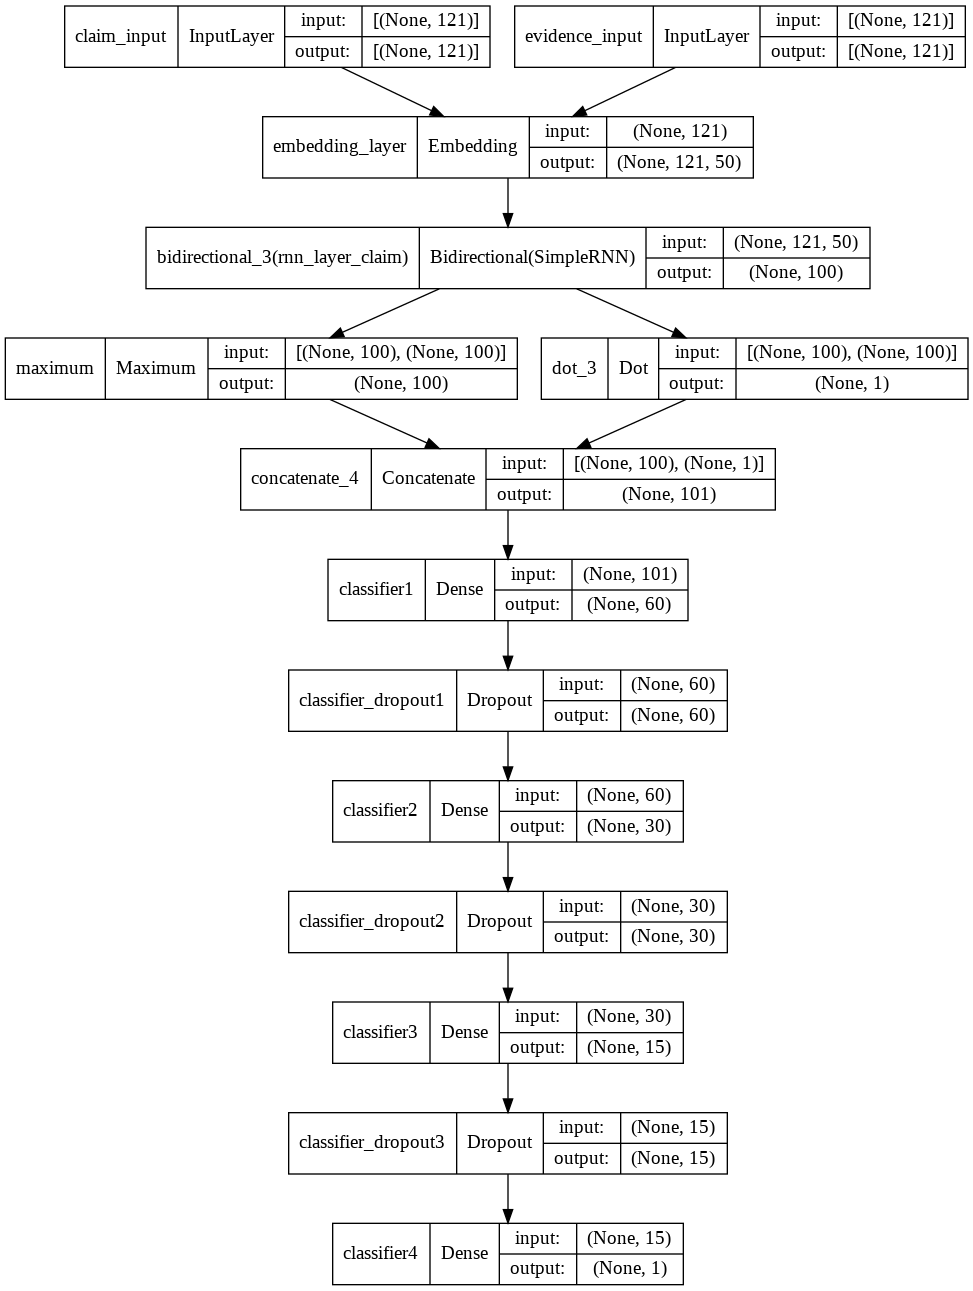

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(end_to_end_add, show_shapes = True)
plot_model(end_to_end_average, show_shapes = True)
plot_model(end_to_end_concat, show_shapes = True)
plot_model(end_to_end_maximum, show_shapes = True)

In [ ]:
checkpoint = [EarlyStopping(monitor = 'val_loss', 
                            patience = 5,
                            verbose = 1,
                            mode = 'auto'),
              ModelCheckpoint(filepath = './models/end_to_end_add.h5',
                              monitor = 'val_binary_accuracy',
                              verbose = 1,
                              save_best_only = True)]

The following code is just to handle the loading and training of a previously trained model.

In [ ]:
LOAD_MODEL = [True, True, True, False]
FIT_MODEL = [False, False, False, True]

In [ ]:
if LOAD_MODEL[0]:
  end_to_end_add = load_model(filepath = './models/end_to_end_add.h5',
                            # custom_objects = {'focal_loss': focal_loss.BinaryFocalLoss(gamma = 2), }
                            ) 


In [ ]:
# Train the model.
if FIT_MODEL[0]:
  end_to_end_add.fit(x = (train_claim, train_evidence), y = np.array(train['Label']),
                   validation_data = ((val_claim, val_evidence), np.array(val['Label'])),
                   batch_size = 64,
                   epochs = 100, callbacks = checkpoint)

Epoch 1/100
1903/1903 [==============================] - ETA: 0s - loss: 0.1319 - binary_accuracy: 0.7777
Epoch 00001: val_binary_accuracy improved from -inf to 0.61703, saving model to ./models/end_to_end_add.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1903/1903 [==============================] - 935s 489ms/step - loss: 0.1319 - binary_accuracy: 0.7777 - val_loss: 0.1750 - val_binary_accuracy: 0.6170
Epoch 2/100
1903/1903 [==============================] - ETA: 0s - loss: 0.1314 - binary_accuracy: 0.7787
Epoch 00002: val_binary_accuracy did not improve from 0.61703
1903/1903 [==============================] - 872s 458ms/step - loss: 0.1314 - binary_accuracy: 0.7787 - val_loss: 0.1728 - val_binary_accuracy: 0.6131
Epoch 3/100
1903/1903 [==============================] - ETA: 0s - loss: 0.1307 - binary_accuracy: 0.7811
Epoch 00003: val_binary_accuracy improved from 0.61703 to 0.62610, saving model to ./models/end_to_end_add.h5
1903/1903 [==============================] - 936s 492ms/step - loss: 0.1307 - binary_accuracy: 0.7811 - val_loss: 0.1670 - val_binary_accuracy: 0.6261
Epoch 4/100
1903/1903 [==============================] - ETA: 0s - loss: 0.1307 - binary_accuracy: 0.7807
Epoch 00004: val_binary_accuracy improved from 0.62610 to

In [ ]:
if LOAD_MODEL[1]:
  end_to_end_average = load_model(filepath = './models/end_to_end_average.h5')

In [ ]:
if FIT_MODEL[1]:
  checkpoint[-1]=ModelCheckpoint(filepath = './models/end_to_end_average.h5',
                              monitor = 'val_binary_accuracy',
                              verbose = 1,
                              save_best_only = True)
  end_to_end_average.fit(x = (test_claim, test_evidence), y = np.array(test['Label']),
                   validation_data = ((val_claim, val_evidence), np.array(val['Label'])),
                   batch_size = 64,
                   epochs = 100, callbacks = checkpoint)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 0.6182 - binary_accuracy: 0.5006
Epoch 00001: val_binary_accuracy improved from -inf to 0.50998, saving model to ./models/end_to_end_add.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


113/113 [==============================] - 90s 738ms/step - loss: 0.6182 - binary_accuracy: 0.5006 - val_loss: 0.2148 - val_binary_accuracy: 0.5100
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.3965 - binary_accuracy: 0.5073
Epoch 00002: val_binary_accuracy did not improve from 0.50998
113/113 [==============================] - 59s 522ms/step - loss: 0.3965 - binary_accuracy: 0.5073 - val_loss: 0.2009 - val_binary_accuracy: 0.5084
Epoch 3/100
113/113 [==============================] - ETA: 0s - loss: 0.3057 - binary_accuracy: 0.5042
Epoch 00003: val_binary_accuracy improved from 0.50998 to 0.52338, saving model to ./models/end_to_end_add.h5
113/113 [==============================] - 84s 747ms/step - loss: 0.3057 - binary_accuracy: 0.5042 - val_loss: 0.1943 - val_binary_accuracy: 0.5234
Epoch 4/100
113/113 [==============================] - ETA: 0s - loss: 0.2565 - binary_accuracy: 0.5016
Epoch 00004: val_binary_accuracy improved from 0.52338 to 0.52408, savin

In [ ]:
if LOAD_MODEL[2]: 
  end_to_end_concat =  load_model(filepath = './models/end_to_end_concat.h5')

In [ ]:
# Train the model.
if FIT_MODEL[2]:
  checkpoint[-1]=ModelCheckpoint(filepath = './models/end_to_end_concat.h5',
                              monitor = 'val_binary_accuracy',
                              verbose = 1,
                              save_best_only = True)
  end_to_end_concat.fit(x = (train_claim, train_evidence), y = np.array(train['Label']),
                      validation_data = ((val_claim, val_evidence), np.array(val['Label'])), 
                      batch_size = 64,
                      epochs = 50, callbacks = checkpoint)

Epoch 1/50
1903/1903 [==============================] - ETA: 0s - loss: 0.2219 - binary_accuracy: 0.6890
Epoch 00001: val_binary_accuracy improved from -inf to 0.50398, saving model to ./models/end_to_end_concat.h5
1903/1903 [==============================] - 939s 491ms/step - loss: 0.2219 - binary_accuracy: 0.6890 - val_loss: 0.2209 - val_binary_accuracy: 0.5040
Epoch 2/50
1903/1903 [==============================] - ETA: 0s - loss: 0.1634 - binary_accuracy: 0.7342
Epoch 00002: val_binary_accuracy improved from 0.50398 to 0.51975, saving model to ./models/end_to_end_concat.h5
1903/1903 [==============================] - 937s 492ms/step - loss: 0.1634 - binary_accuracy: 0.7342 - val_loss: 0.2072 - val_binary_accuracy: 0.5197
Epoch 3/50
1903/1903 [==============================] - ETA: 0s - loss: 0.1480 - binary_accuracy: 0.7426
Epoch 00003: val_binary_accuracy improved from 0.51975 to 0.59093, saving model to ./models/end_to_end_concat.h5
1903/1903 [==============================] - 94

In [ ]:
if LOAD_MODEL[3]:
  end_to_end_maximum = load_model(filepath = './models/end_to_end_max.h5')

In [ ]:
if FIT_MODEL[3]:
  checkpoint[-1] = ModelCheckpoint(filepath = './models/end_to_end_max.h5',
                              monitor = 'val_binary_accuracy',
                              verbose = 1,
                              save_best_only = True)
  end_to_end_maximum.fit(x = (train_claim, train_evidence), y = np.array(train['Label']),
                       validation_data = ((val_claim, val_evidence), np.array(val['Label'])),
                       batch_size = 64,
                       epochs = 100, callbacks = checkpoint)

## Evaluation

### A. Classification metrics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

def evaluate_model_A(model: tf.keras.Model, test_set: tuple, test_labels):
    pred = model.predict(test_set)

    pred_thr = np.zeros(pred.shape)
    pred_thr[pred >= 0.5] = 1
    pred_thr[pred < 0.5] = 0

    print(classification_report(pred_thr, test_labels))

    bin_acc = accuracy_score(pred_thr, test_labels)
    print(f'The binary accuracy is: {bin_acc}.')
    return bin_acc

evaluate_model_A(end_to_end_add, (test_claim, test_evidence), np.array(test['Label']))
evaluate_model_A(end_to_end_average, (test_claim, test_evidence), np.array(test['Label']))
evaluate_model_A(end_to_end_concat, (test_claim, test_evidence), np.array(test['Label']))

              precision    recall  f1-score   support

         0.0       0.35      0.84      0.49      1501
         1.0       0.93      0.59      0.72      5688

    accuracy                           0.64      7189
   macro avg       0.64      0.71      0.61      7189
weighted avg       0.81      0.64      0.68      7189

The binary accuracy is: 0.6425093893448324.


0.6425093893448324

### B. Majority voting metrics


In [ ]:
def build_dataframe_from_model(model: tf.keras.Model, dataframe: pd.DataFrame, claim: np.ndarray, evidence: np.ndarray) -> pd.DataFrame:
  # Get predictions from trained model.
  predictions = model.predict((claim, evidence))

  # Create a new dataframe.
  predictions_df = pd.DataFrame()
  # The claims are the same.
  predictions_df["Claim"] = dataframe["Claim"]

  # The predictions are taken from the model and mapped to supports/refutes.
  predictions_df["Label"] = np.rint(predictions)
  predictions_df["Label"] = predictions_df["Label"].apply(lambda x: "supports" if x == 1 else "refutes")
  
  return predictions_df

def majority_voting(dataframe: pd.DataFrame) -> np.ndarray:
  # Create a new dataframe with results column.
  unique_claims = pd.DataFrame(columns = ["Claim", "Result"])
  unique_claims["Claim"] = pd.unique(dataframe["Claim"]) 

  for claim in unique_claims["Claim"]:
    labels = dataframe[dataframe["Claim"] == claim]
    supports = len(labels[labels["Label"] == "supports"])
    refutes = len(labels[labels["Label"] == "refutes"])
    
    # Count the evidences that support or refutes the claim to cast a vote.
    if supports > refutes :
      unique_claims["Result"][unique_claims["Claim"] == claim] = 1
    else :
      unique_claims["Result"][unique_claims["Claim"] == claim] = 0

  return unique_claims

def compute_metrics_majority_vote(true_values, predicted_values):
  print("Accuracy: ", accuracy_score(true_values, predicted_values))
  print("Precision: ", precision_score(true_values, predicted_values))
  print("Recall: ", recall_score(true_values, predicted_values))
  print("F1 score: ", f1_score(true_values, predicted_values))

true_values = majority_voting(df_test_m)["Result"].to_numpy(int)

In [ ]:
# Model 'add'.
print('end_to_end_add')
predicted_values = build_dataframe_from_model(end_to_end_add, df_test_m, test_claim, test_evidence)
predicted_values = majority_voting(predicted_values)["Result"].to_numpy(int)
compute_metrics_majority_vote(true_values, predicted_values)

print('end_to_end_average')
# Model 'average'.
predicted_values = build_dataframe_from_model(end_to_end_average, df_test_m, test_claim, test_evidence)
predicted_values = majority_voting(predicted_values)["Result"].to_numpy(int)
compute_metrics_majority_vote(true_values, predicted_values)

print('end_to_end_concat')
# Model 'concat'.
predicted_values = build_dataframe_from_model(end_to_end_concat, df_test_m, test_claim, test_evidence)
predicted_values = majority_voting(predicted_values)["Result"].to_numpy(int)
compute_metrics_majority_vote(true_values, predicted_values)

end_to_end_add
Accuracy:  0.6419868791002812
Precision:  0.5886201427438541
Recall:  0.9318895166352793
F1 score:  0.7215066828675577


'\nprint(\'end_to_end_average\')\n# Model \'average\'.\npredicted_values = build_dataframe_from_model(end_to_end_average, df_test_m, test_claim, test_evidence)\npredicted_values = majority_voting(predicted_values)["Result"].to_numpy(int)\ncompute_metrics_majority_vote(true_values, predicted_values)\n\nprint(\'end_to_end_concat\')\n# Model \'concat\'.\npredicted_values = build_dataframe_from_model(end_to_end_concat, df_test_m, test_claim, test_evidence)\npredicted_values = majority_voting(predicted_values)["Result"].to_numpy(int)\ncompute_metrics_majority_vote(true_values, predicted_values)\n'